In [1]:

def plot_rt(result_df, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result_df['ML'].index.get_level_values('date')
    start_date = index[0] - pd.Timedelta(days=1)
    values = result_df['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result_df['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result_df['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=start_date,
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=-1)
    
    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(start_date, result_df.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [27]:

def highest_density_interval(pmf, p=.9):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    if (lows.size == 0) or (highs.size == 0):
    
        return pd.Series([np.nan, np.nan], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'], dtype='float64')
    
    else:
        
        # Find the smallest range (highest density)
        best = (highs - lows).argmin()

        low = pmf.index[lows[best]]
        high = pmf.index[highs[best]]

        return pd.Series([low, high],
                         index=[f'Low_{p*100:.0f}',
                                f'High_{p*100:.0f}'])

In [37]:

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from scipy.interpolate import interp1d
from matplotlib.dates import date2num
from matplotlib import dates as mdates
from matplotlib import ticker
%run ../../load_magic/storage.py
s = Storage()

def show_one_state(state_name):
    final_results = s.load_object('final_results')
    mask_series = (final_results.index.get_level_values('state') == state_name)
    result_df = final_results[mask_series]
    fig, ax = plt.subplots(figsize=(18, 18/1.19))
    plot_rt(result_df, ax, state_name)
    ax.set_title(f"Real-time $R_t$ for {state_name} as of {result_df.index[-1][1].strftime('%B %d')}")
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    legend_obj = ax.legend()

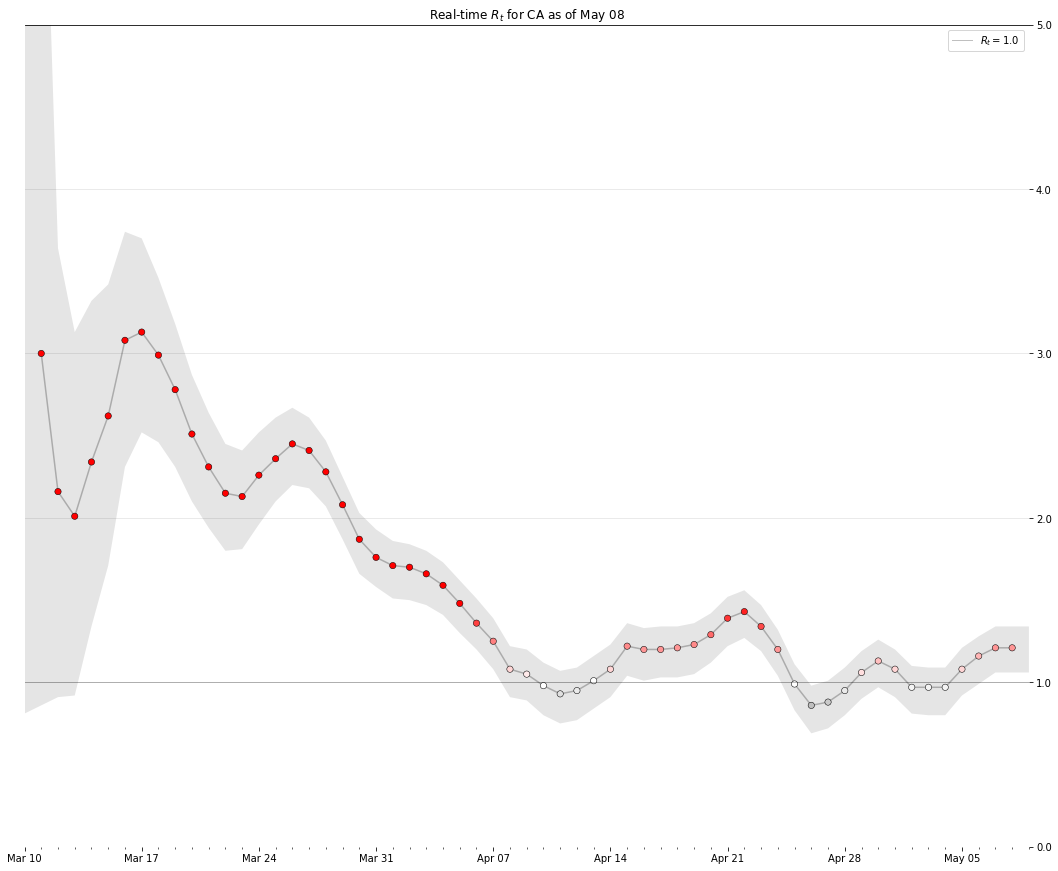

In [39]:

show_one_state('CA')

In [57]:

print(['pd.{}'.format(fn) for fn in dir(pd) if 'time' in fn.lower()])

['pd.DatetimeIndex', 'pd.DatetimeTZDtype', 'pd.Timedelta', 'pd.TimedeltaIndex', 'pd.Timestamp', 'pd.timedelta_range', 'pd.to_datetime', 'pd.to_timedelta']


In [46]:

url = r'D:\Documents\Repositories\notebooks\covid19\data\csv\navaho_nation_cumulative_cases.csv'
navaho_series = pd.read_csv(url,
                            usecols=['date', 'state', 'positive'],
                            parse_dates=['date'],
                            index_col=['state', 'date'],
                            squeeze=True).sort_index()
navaho_series

state  date      
NN     2020-03-17       1
       2020-03-20      14
       2020-04-12     698
       2020-04-18    1197
       2020-05-02    2373
Name: positive, dtype: int64

In [50]:

url = 'https://covidtracking.com/api/v1/states/daily.csv'
states_series = pd.read_csv(url,
                            usecols=['date', 'state', 'positive'],
                            parse_dates=['date'],
                            index_col=['state', 'date'],
                            squeeze=True).sort_index()
mask_series = (states_series.index.get_level_values('state') == 'AZ')
states_series = states_series[mask_series]
for column_name, column_value in states_series.iteritems():
    print(column_name, column_value)

('AZ', Timestamp('2020-03-04 00:00:00')) 2.0
('AZ', Timestamp('2020-03-05 00:00:00')) 2.0
('AZ', Timestamp('2020-03-06 00:00:00')) 3.0
('AZ', Timestamp('2020-03-07 00:00:00')) 5.0
('AZ', Timestamp('2020-03-08 00:00:00')) 5.0
('AZ', Timestamp('2020-03-09 00:00:00')) 5.0
('AZ', Timestamp('2020-03-10 00:00:00')) 6.0
('AZ', Timestamp('2020-03-11 00:00:00')) 9.0
('AZ', Timestamp('2020-03-12 00:00:00')) 9.0
('AZ', Timestamp('2020-03-13 00:00:00')) 9.0
('AZ', Timestamp('2020-03-14 00:00:00')) 12.0
('AZ', Timestamp('2020-03-15 00:00:00')) 12.0
('AZ', Timestamp('2020-03-16 00:00:00')) 18.0
('AZ', Timestamp('2020-03-17 00:00:00')) 20.0
('AZ', Timestamp('2020-03-18 00:00:00')) 28.0
('AZ', Timestamp('2020-03-19 00:00:00')) 44.0
('AZ', Timestamp('2020-03-20 00:00:00')) 65.0
('AZ', Timestamp('2020-03-21 00:00:00')) 104.0
('AZ', Timestamp('2020-03-22 00:00:00')) 152.0
('AZ', Timestamp('2020-03-23 00:00:00')) 265.0
('AZ', Timestamp('2020-03-24 00:00:00')) 357.0
('AZ', Timestamp('2020-03-25 00:00:00'))

In [80]:

state = 'NN'
index_list = []
positive_list = []
for datetime_idx in pd.date_range(states_series.index.get_level_values('date').min(),
                                  states_series.index.get_level_values('date').max()):
    date = pd.Timestamp(datetime_idx, freq=None)
    date = pd.Timestamp(year=datetime_idx.year, month=datetime_idx.month, day=datetime_idx.day)
    mask_series = (navaho_series.index.get_level_values('state') == state)
    mask_series = mask_series & (navaho_series.index.get_level_values('date') == date)
    index_tuple = ('AZ', date)
    index_list.append(index_tuple)
    if navaho_series[mask_series].shape[0] == 0:
        positive_list.append(np.nan)
    else:
        positive_list.append(navaho_series[mask_series].squeeze())

In [81]:

navaho_series = pd.Series(positive_list, index=index_list)

In [86]:

navaho_series = navaho_series.ffill()
navaho_series = navaho_series.fillna(0)

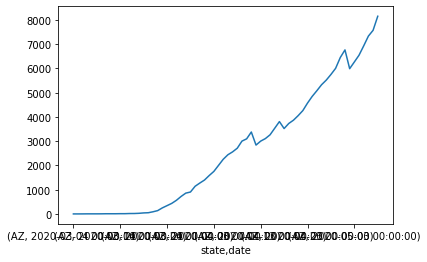

In [89]:

new_series = (states_series - navaho_series)
new_series.plot.line()

In [91]:

def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

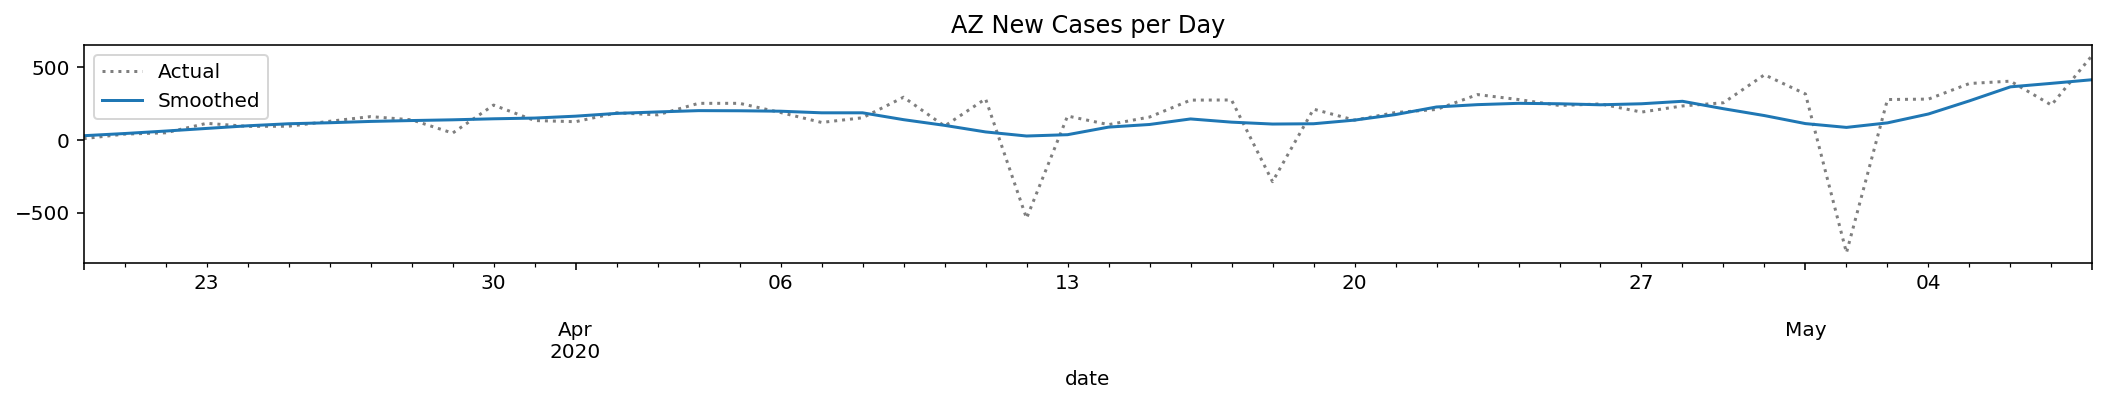

In [92]:

%run ../../load_magic/charts.py
state_name = 'AZ'
cases = new_series.xs(state_name).rename(f'{state_name} cases')
original, smoothed = prepare_cases(cases)
ax = original.plot(title=f'{state_name} New Cases per Day',
                   c='k',
                   linestyle=':',
                   alpha=.5,
                   label='Actual',
                   legend=True,
                   figsize=(18, 18/9))
smoothed.plot(label='Smoothed', legend=True, ax=ax)
ax.get_figure().set_facecolor('w')
legend_obj = ax.legend()

In [97]:

from scipy import stats as sps

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

In [98]:

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors_df = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors_df[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors_df[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors_df, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors_df, log_likelihood = get_posteriors(smoothed, sigma=.25)
#s.store_objects(posteriors_df=posteriors_df)

In [100]:

# Note that this takes a while to execute - it's not the most efficient algorithm
hdis_df = highest_density_interval(posteriors_df, p=.9)

most_likely = posteriors_df.idxmax().rename('ML')

# Look into why you shift -1
result_df = pd.concat([most_likely, hdis_df], axis=1)
mask_series = result_df.Low_90.isnull() | result_df.High_90.isnull()
result_df = result_df[~mask_series]

result_df.tail()

,ML,Low_90,High_90
date,,,
2020-05-04,1.84,1.22,2.39
2020-05-05,2.83,2.28,3.32
2020-05-06,3.00,2.52,3.42
2020-05-07,2.17,1.72,2.55
2020-05-08,1.79,1.35,2.16


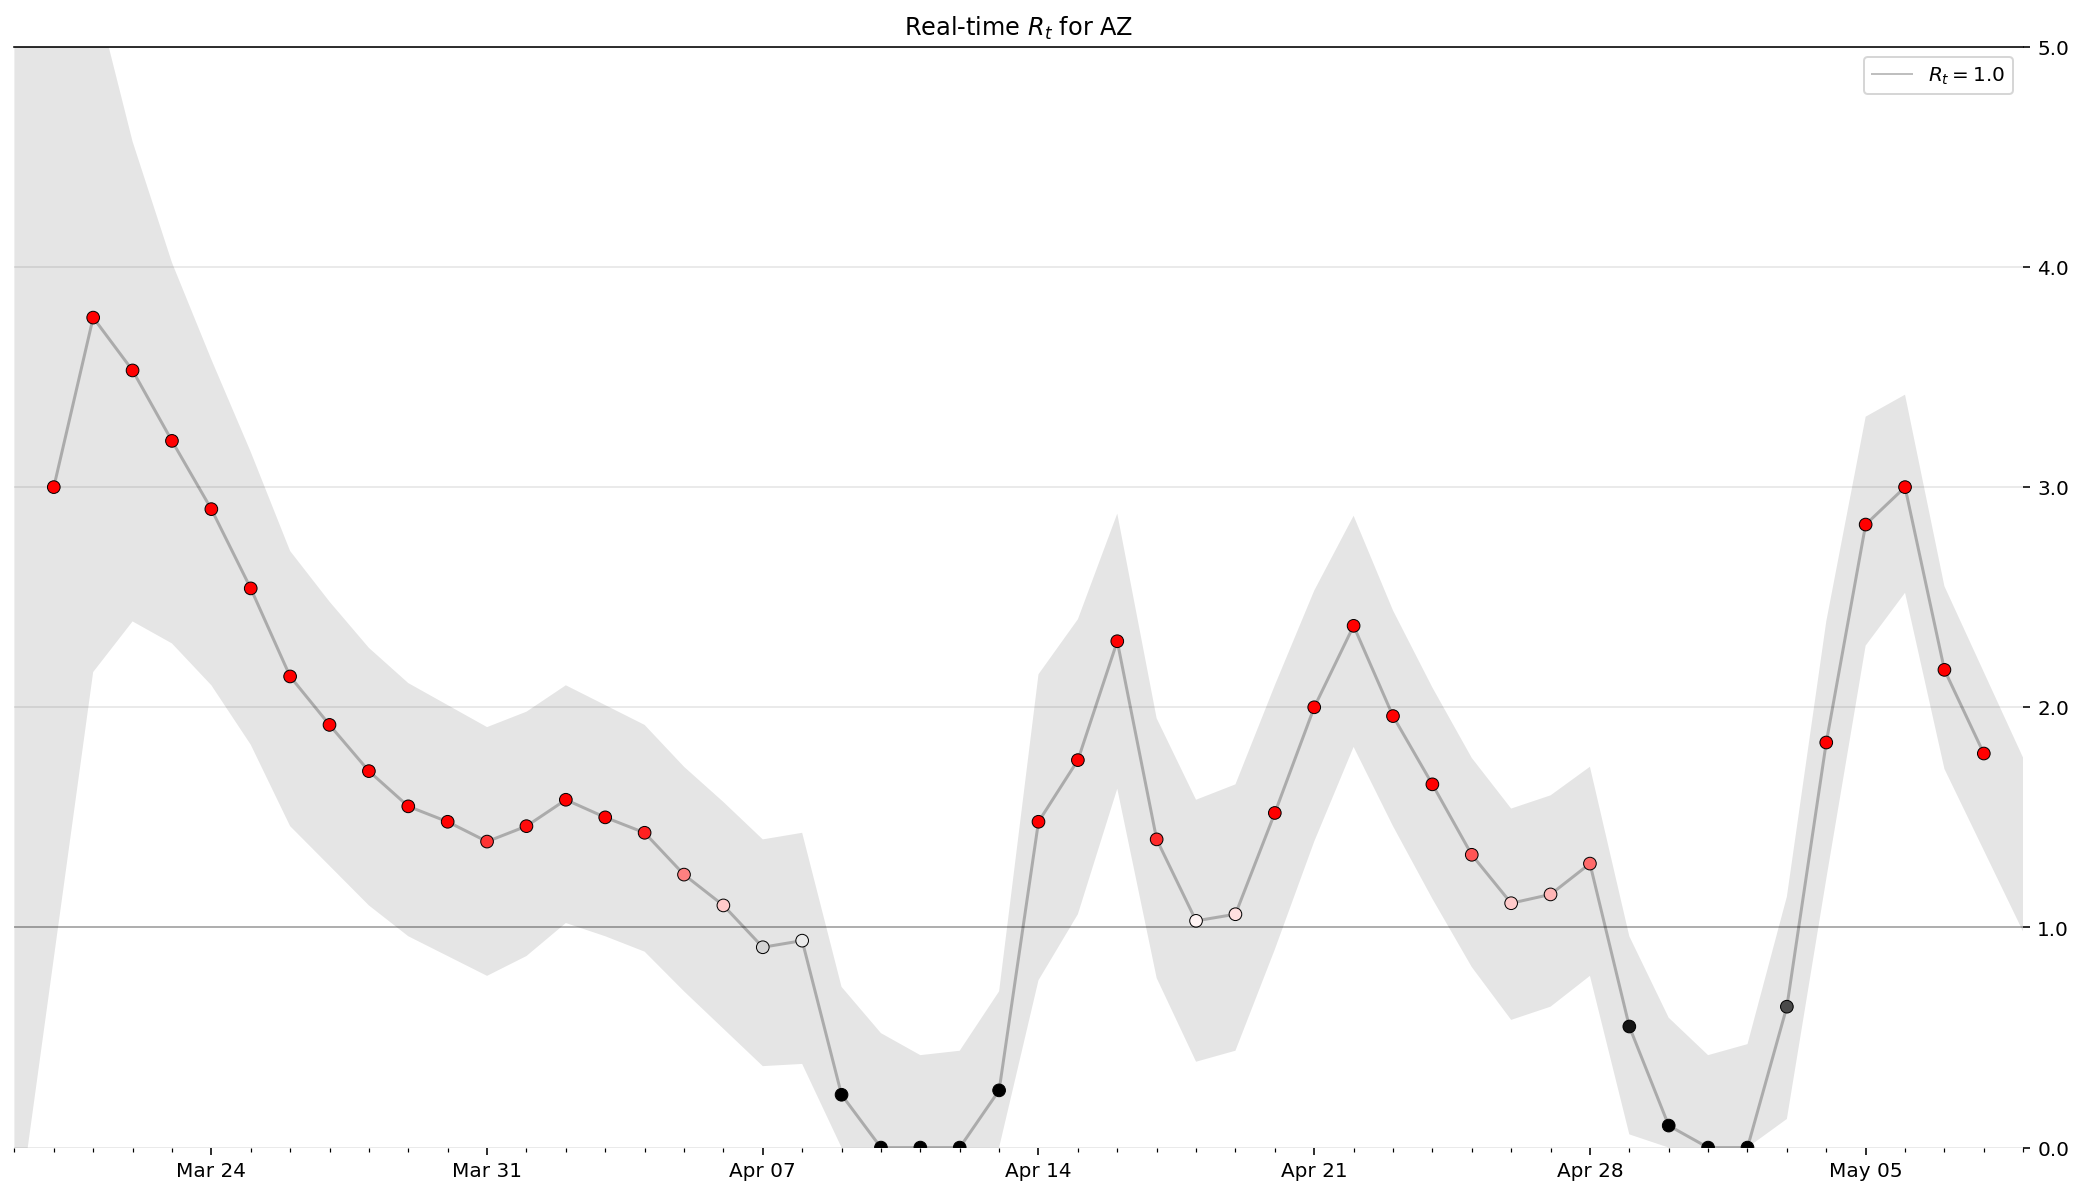

In [104]:

def plot_rt(result_df, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result_df['ML'].index.get_level_values('date')
    start_date = index[0] - pd.Timedelta(days=1)
    values = result_df['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result_df['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result_df['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=start_date,
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=-1)
    
    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(start_date, result_df.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

twitter_aspect_ratio = 16/9
fig, ax = plt.subplots(figsize=(18, 18/TWITTER_ASPECT_RATIO))

plot_rt(result_df, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
legend_obj = ax.legend()

In [103]:

dir()

['FACEBOOK_ASPECT_RATIO',
 'GAMMA',
 'In',
 'ListedColormap',
 'Out',
 'R_T_MAX',
 'Storage',
 'TWITTER_ASPECT_RATIO',
 '_',
 '_100',
 '_20',
 '_22',
 '_25',
 '_40',
 '_41',
 '_42',
 '_44',
 '_45',
 '_46',
 '_47',
 '_48',
 '_49',
 '_51',
 '_55',
 '_56',
 '_59',
 '_62',
 '_72',
 '_73',
 '_75',
 '_76',
 '_77',
 '_79',
 '_82',
 '_83',
 '_84',
 '_85',
 '_87',
 '_88',
 '_89',
 '_90',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__nonzero__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i100',
 '_i101',
 '_i102',
 '_i103',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i44',
 '_i45',
 '_i46',
 '_i47',
 '_i48',
 '_i49',
 '_i5',
 '_i50',
 '_i51',
 '_i52',
 '_

In [99]:

print(['datetime_idx.{}'.format(fn) for fn in dir(datetime_idx) if not fn.startswith('_')])

['datetime_idx.asm8', 'datetime_idx.astimezone', 'datetime_idx.ceil', 'datetime_idx.combine', 'datetime_idx.ctime', 'datetime_idx.date', 'datetime_idx.day', 'datetime_idx.day_name', 'datetime_idx.dayofweek', 'datetime_idx.dayofyear', 'datetime_idx.days_in_month', 'datetime_idx.daysinmonth', 'datetime_idx.dst', 'datetime_idx.floor', 'datetime_idx.fold', 'datetime_idx.freq', 'datetime_idx.freqstr', 'datetime_idx.fromisoformat', 'datetime_idx.fromordinal', 'datetime_idx.fromtimestamp', 'datetime_idx.hour', 'datetime_idx.is_leap_year', 'datetime_idx.is_month_end', 'datetime_idx.is_month_start', 'datetime_idx.is_quarter_end', 'datetime_idx.is_quarter_start', 'datetime_idx.is_year_end', 'datetime_idx.is_year_start', 'datetime_idx.isocalendar', 'datetime_idx.isoformat', 'datetime_idx.isoweekday', 'datetime_idx.max', 'datetime_idx.microsecond', 'datetime_idx.min', 'datetime_idx.minute', 'datetime_idx.month', 'datetime_idx.month_name', 'datetime_idx.nanosecond', 'datetime_idx.normalize', 'datet